In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
import warnings
warnings.filterwarnings('ignore')
import joblib

In [13]:
def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [2]:
features_data = pd.read_csv('../data/Features_data_set.csv')
sales_data = pd.read_csv('../data/sales_data_set.csv')
stores_data = pd.read_csv('../data/stores_data_set.csv')

In [7]:
print(features_data.columns)
features_data.head()

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
print(sales_data.columns)
sales_data.head()

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [8]:
print(stores_data.columns)
stores_data.head()

Index(['Store', 'Type', 'Size'], dtype='object')


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


<AxesSubplot:xlabel='Date', ylabel='IsHoliday'>

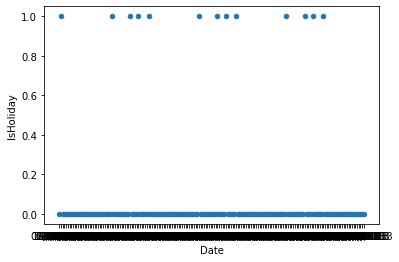

In [9]:
tmp_df = features_data[['Date', 'IsHoliday']].drop_duplicates()
tmp_df.Data = pd.to_datetime(tmp_df.Date, format = '%d/%m/%Y')
tmp_df.IsHoliday = tmp_df.IsHoliday.astype('int')
tmp_df.plot(x = 0, y = 1,kind = 'scatter')

In [10]:
#holidays are correlated with week of year, so I won't use it

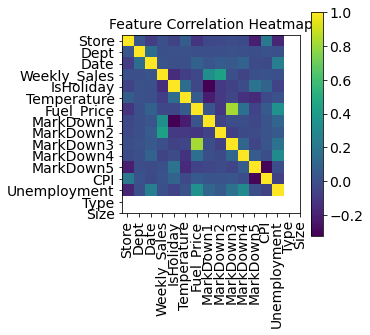

In [11]:
df = pd.merge(sales_data, features_data, on=['Date', 'Store'], how = 'left')
if all(df.IsHoliday_x.values == df.IsHoliday_y.values):
        df.drop('IsHoliday_y', axis=1, inplace=True)
        df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

df = pd.merge(df, stores_data, on='Store', how='left')
df.Date = pd.to_datetime(df.Date, format = '%d/%m/%Y')
ori_df = df.copy()


def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [14]:
#creating date features
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['week_of_year'] = df.Date.dt.weekofyear
df['week_of_month'] = df.Date.map(week_of_month)
date_features = list(df.columns[-4:])

count    421570.000000
mean          2.943134
std           1.299199
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: week_of_month, dtype: float64

count    421570.000000
mean         25.826762
std          14.151887
min           1.000000
25%          14.000000
50%          26.000000
75%          38.000000
max          52.000000
Name: week_of_year, dtype: float64

count    421570.000000
mean       2010.968591
std           0.796876
min        2010.000000
25%        2010.000000
50%        2011.000000
75%        2012.000000
max        2012.000000
Name: year, dtype: float64

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

count    1285.000000
mean      -68.608218
std       231.664245
min     -4988.940000
25%       -41.000000
50%       -13.200000
75%        -4.940000
max        -0.020000
Name: Weekly_Sales, dtype: float64

0.30481296107408024


<AxesSubplot:>

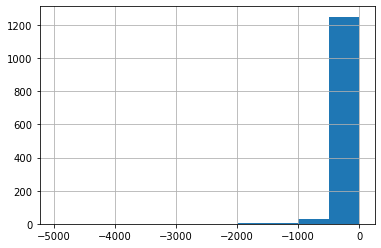

In [15]:
display(df.week_of_month.describe())
display(df.week_of_year.describe())
display(df.year.describe())
display(df.Weekly_Sales.describe())
display(df[df.Weekly_Sales<0].Weekly_Sales.describe())
print(df[df.Weekly_Sales<0].shape[0]/df.shape[0]*100)
df[df.Weekly_Sales<0].Weekly_Sales.hist()

In [16]:
# I assume negative weekly sales means there was more returns than sales
# I will replace negative values with 0 to cut down on the noise (about 3% of the data)
df['Weekly_Sales'].loc[df.Weekly_Sales<1] = 0

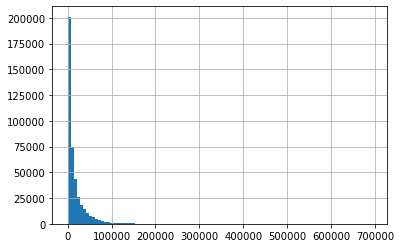

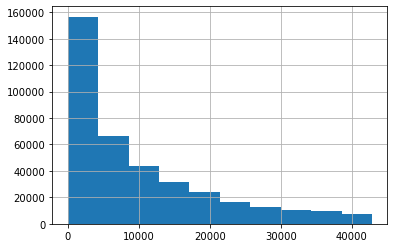

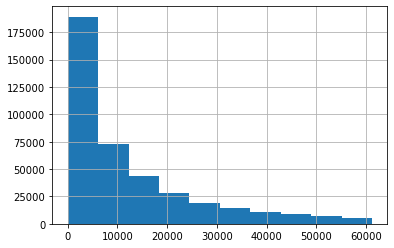

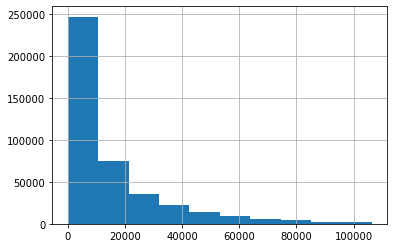

In [17]:
(df.Weekly_Sales).hist(bins=100)
plt.show()
for q in [0.9, 0.95, 0.99]:
    df.loc[df.Weekly_Sales < np.quantile(df.Weekly_Sales, q)].Weekly_Sales.hist()
    plt.show()

<AxesSubplot:>

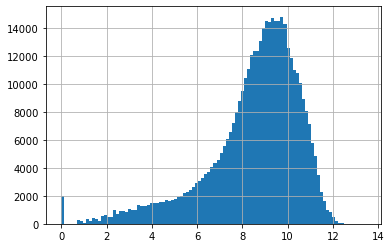

In [18]:
np.log1p(df.Weekly_Sales).hist(bins=100)

In [ ]:
#I will cut off outlier values at 98% quantile as distribution for lgbm doesnt have to be normal I wont logarithmize the target
df['Weekly_Sales'].loc[(df.Weekly_Sales > np.quantile(df.Weekly_Sales, 0.98))&(df.year != 2012)] = np.quantile(df.Weekly_Sales, 0.98)


In [20]:
#back to ori_df i will do some EDA about total sales
df = ori_df.copy()
df = df.groupby(['Date']).Weekly_Sales.sum().reset_index().rename(columns = {'Weekly_Sales':'total_sales'})
df

,Date,total_sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30
...,...,...
138,2012-09-28,43734899.40
139,2012-10-05,47566639.31
140,2012-10-12,46128514.25
141,2012-10-19,45122410.57


In [21]:
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['week_of_year'] = df.Date.dt.weekofyear
df['week_of_month'] = df.Date.map(week_of_month)


<AxesSubplot:>

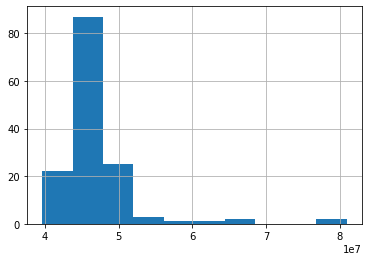

In [22]:
df.total_sales.hist()

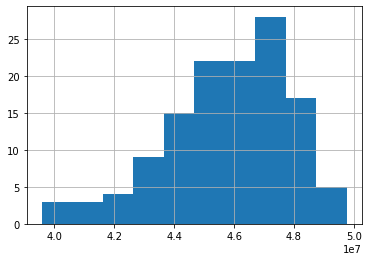

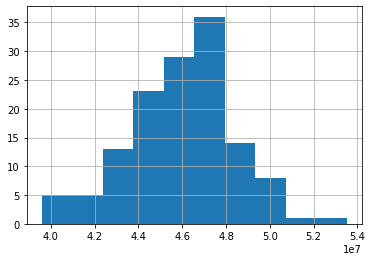

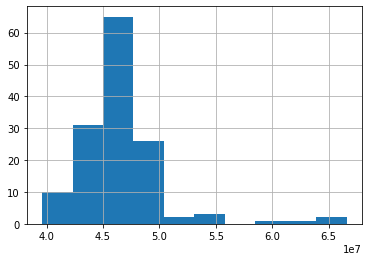

In [23]:
for q in [0.9, 0.95, 0.99]:
    df.loc[df.total_sales < np.quantile(df.total_sales, q)].total_sales.hist()
    plt.show()

In [24]:
df = ori_df.copy()
df = df[['Store','Dept','Date', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']]
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['week_of_year'] = df.Date.dt.weekofyear
df['week_of_month'] = df.Date.map(week_of_month)
df = df.dropna()

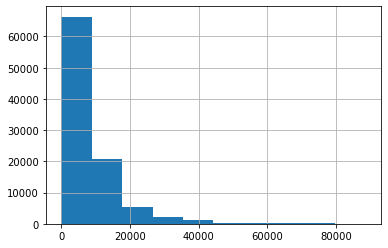

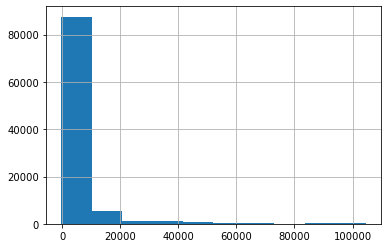

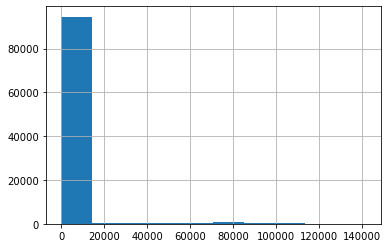

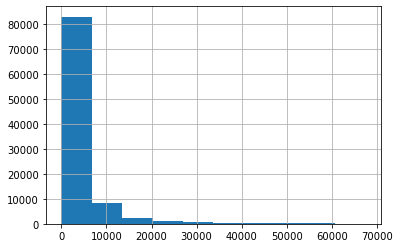

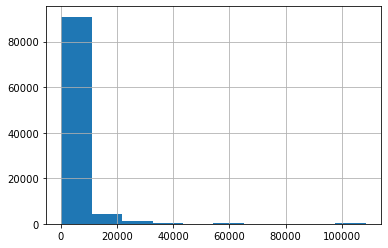

In [26]:
for idx in range(1,6):
    df[f'MarkDown{idx}'].hist()
    plt.show()

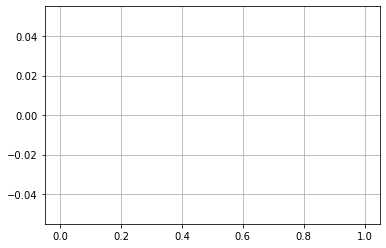

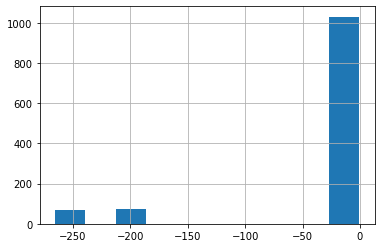

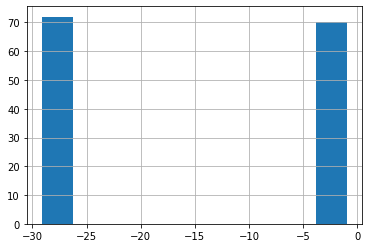

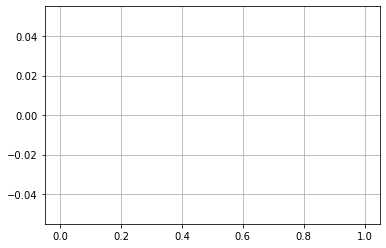

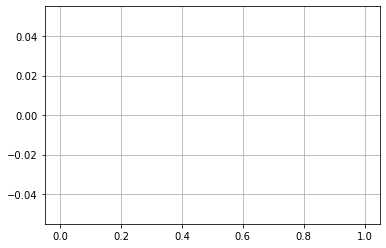

In [25]:
for idx in range(1,6):
    markdown = f'MarkDown{idx}'
    df[df[markdown]<0][markdown].hist()
    plt.show()

markdown MarkDown1 cutted to quantile 0.9


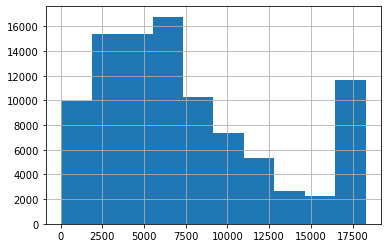

markdown MarkDown2 cutted to quantile 0.9


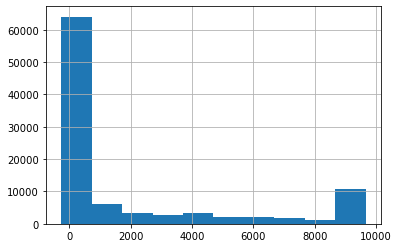

markdown MarkDown3 cutted to quantile 0.9


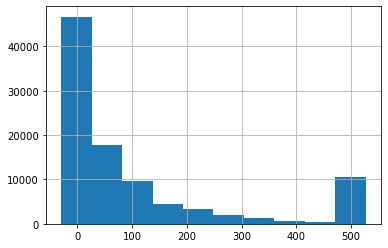

markdown MarkDown4 cutted to quantile 0.9


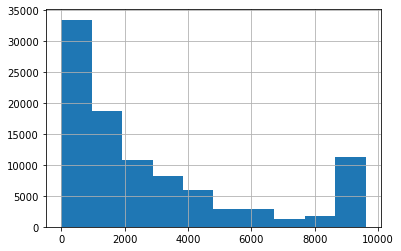

markdown MarkDown5 cutted to quantile 0.9


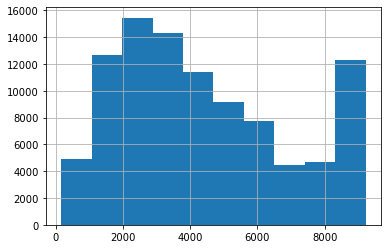

markdown MarkDown1 cutted to quantile 0.95


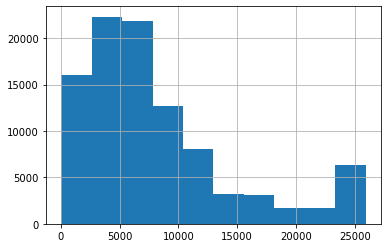

markdown MarkDown2 cutted to quantile 0.95


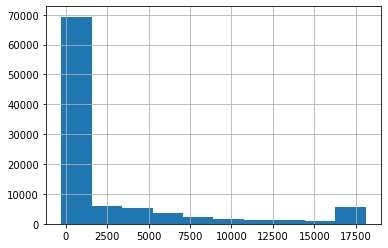

markdown MarkDown3 cutted to quantile 0.95


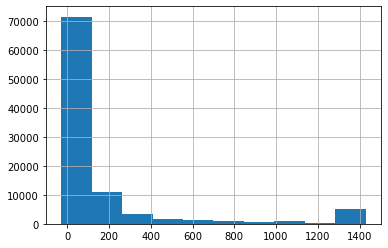

markdown MarkDown4 cutted to quantile 0.95


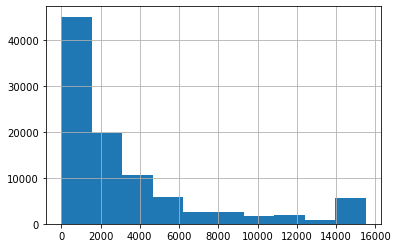

markdown MarkDown5 cutted to quantile 0.95


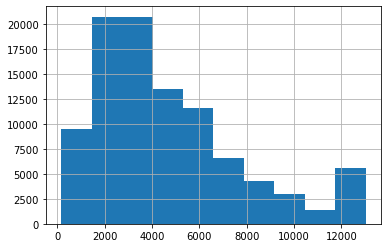

markdown MarkDown1 cutted to quantile 0.98


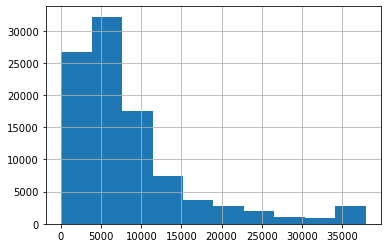

markdown MarkDown2 cutted to quantile 0.98


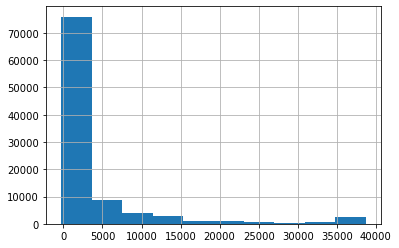

markdown MarkDown3 cutted to quantile 0.98


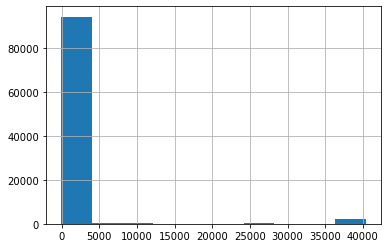

markdown MarkDown4 cutted to quantile 0.98


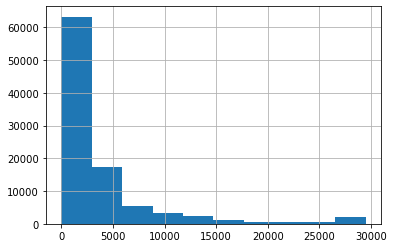

markdown MarkDown5 cutted to quantile 0.98


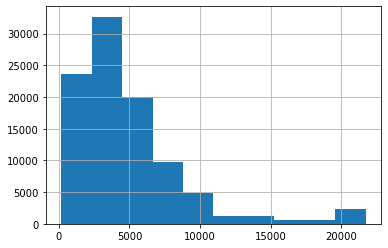

markdown MarkDown1 cutted to quantile 0.99


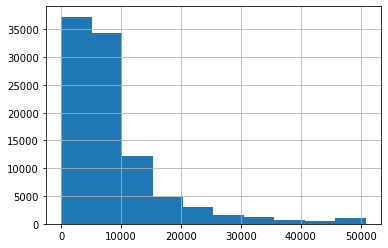

markdown MarkDown2 cutted to quantile 0.99


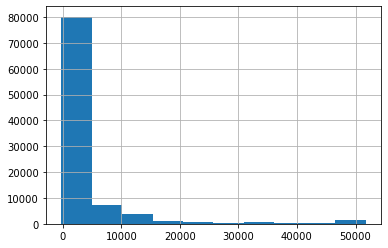

markdown MarkDown3 cutted to quantile 0.99


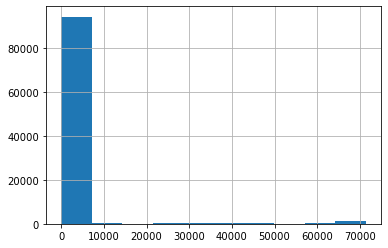

markdown MarkDown4 cutted to quantile 0.99


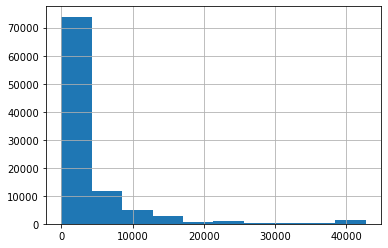

markdown MarkDown5 cutted to quantile 0.99


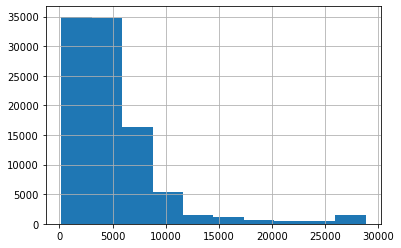

In [28]:
for q in [.9, .95, .98, .99]:
    for idx in range(1,6):
        markdown = f'MarkDown{idx}'
        tmp_df = df.copy()
        t = np.quantile(tmp_df[markdown], q)
        tmp_df[markdown].loc[tmp_df[markdown] > t] = t
        tmp_df[markdown].hist()
        print(f'markdown {markdown} cutted to quantile {q}')
        plt.show()